In [1]:
using Distributions
using Optim
using Printf
using Roots
using StatsFuns
using StatsPlots
default(fmt=:png)

safemul(x, y) = x == 0 ? zero(x/y) : isinf(x) ? oftype(x, Inf) : x*y
safediv(x, y) = x == 0 ? zero(x/y) : isinf(y) ? zero(y) : x/y
x ⪅ y = x < y || x ≈ y
_ecdf(A, x) = count(≤(x), A) / length(A)

_ecdf (generic function with 1 method)

In [2]:
# Wald's method for log OR

oddsratiohat(a, b, c, d) = safediv(a*d, b*c)
stderr_logoddsratiohat(a, b, c, d) = √(1/a + 1/b + 1/c + 1/d)

function pvalue_or_wald(a, b, c, d; ω=1)
    logORhat = log(oddsratiohat(a, b, c, d))
    SEhat_logORhat = stderr_logoddsratiohat(a, b, c, d)
    2ccdf(Normal(0, 1), safediv(abs(logORhat - log(ω)), SEhat_logORhat))
end

function confint_or_wald(a, b, c, d; α=0.05)
    z = quantile(Normal(), 1-α/2)
    ORhat = oddsratiohat(a, b, c, d)
    SEhat_logORhat = stderr_logoddsratiohat(a, b, c, d)
    [safemul(exp(-z*SEhat_logORhat), ORhat), safemul(exp(z*SEhat_logORhat), ORhat)]
end

confint_or_wald (generic function with 1 method)

In [3]:
# Wald's method for log RR

riskratiohat(a, b, c, d) = safediv(a*(c+d), (a+b)*c)
stderr_logriskratiohat(a, b, c, d) = √(1/a - 1/(a+b) + 1/c - 1/(c+d))

function pvalue_rr_wald(a, b, c, d; ρ=1)
    (a+b==0 || c+d==0) && return 1.0
    logRRhat = log(riskratiohat(a, b, c, d))
    SEhat_logRRhat = stderr_logriskratiohat(a, b, c, d)
    2ccdf(Normal(0, 1), safediv(abs(logRRhat - log(ρ)), SEhat_logRRhat))
end

function confint_rr_wald(a, b, c, d; α=0.05)
    (a+b==0 || c+d==0) && return [0, Inf]
    z = quantile(Normal(), 1-α/2)
    RRhat = riskratiohat(a, b, c, d)
    SEhat_logRRhat = stderr_logriskratiohat(a, b, c, d)
    [safemul(exp(-z*SEhat_logRRhat), RRhat), safemul(exp(z*SEhat_logRRhat), RRhat)]
end

confint_rr_wald (generic function with 1 method)

In [4]:
# Wald's method for RD

riskdiffhat(a, b, c, d) = safediv(a, a+b) - safediv(c, c+d)

function stderr_riskdiffhat(a, b, c, d)
    m, n = a+b, c+d
    p̂, q̂ = safediv(a, m), safediv(c, n)
    √(safediv(p̂*(1-p̂), m) + safediv(q̂*(1-q̂), n))
end

function pvalue_rd_wald(a, b, c, d; Δ=0)
    RDhat = riskdiffhat(a, b, c, d)
    SEhat_riskdiffhat = stderr_riskdiffhat(a, b, c, d)
    2ccdf(Normal(0, 1), safediv(abs(RDhat - Δ), SEhat_riskdiffhat))
end

function confint_rd_wald(a, b, c, d; α=0.05)
    z = quantile(Normal(), 1-α/2)
    RDhat = riskdiffhat(a, b, c, d)
    SEhat_riskdiffhat = stderr_riskdiffhat(a, b, c, d)
    [RDhat - z*SEhat_riskdiffhat, RDhat + z*SEhat_riskdiffhat]
end

confint_rd_wald (generic function with 1 method)

In [5]:
# Zou-Donner method for RD

riskdiffhat_zou_donner(a, b, c, d) = safediv(a, a+b) - safediv(c, c+d)

function stderr_riskdiffhat_zou_donner(a, b, c, d; u=1)
    m, n = a+b, c+d
    p̂, q̂ = safediv(a, m), safediv(c, n)
    √(safediv(p̂*(1-p̂), m-u) + safediv(q̂*(1-q̂), n-u))
end

function pvalue_rd_zou_donner(a, b, c, d; Δ=0, u=1)
    ((a==0 && d==0) || (b==0 && c==0)) && return 1.0
    RDhat = riskdiffhat_zou_donner(a, b, c, d)
    SEhat_riskdiffhat = stderr_riskdiffhat_zou_donner(a, b, c, d; u)
    Z = safediv((1 - RDhat^2)*abs(atanh(RDhat) - atanh(Δ)), SEhat_riskdiffhat)
    2ccdf(Normal(), abs(Z))
end

function confint_rd_zou_donner(a, b, c, d; α=0.05, u=1)
    z = quantile(Normal(), 1-α/2)
    RDhat = riskdiffhat_zou_donner(a, b, c, d)
    SEhat_riskdiffhat = stderr_riskdiffhat_zou_donner(a, b, c, d; u)
    m = atanh(RDhat)
    d = safediv(z*SEhat_riskdiffhat, 1 - RDhat^2)
    [tanh(m-d), tanh(m+d)]
end

confint_rd_zou_donner (generic function with 1 method)

In [6]:
# score method for OR

function delta(a, b, c, d; ω=1)
    A, B, C = 1-ω, a+d+ω*(b+c), a*d-ω*b*c
    isinf(ω) ? oftype(ω, -min(b, c)) : safediv(2C, B + √(B^2 - 4A*C))
end

# correction = 0.5 は連続性補正を与える.
function _chisqstat_or(a, b, c, d, δ; correction=0.0)
    ã, b̃, c̃, d̃ = a-δ, b+δ, c+δ, d-δ
    safemul(max(0, abs(δ)-correction)^2, 1/ã + 1/b̃ + 1/c̃ + 1/d̃)
end

function chisqstat_or(a, b, c, d; ω=1, correction=0.0)
    δ = delta(a, b, c, d; ω)
    _chisqstat_or(a, b, c, d, δ; correction)
end

function pvalue_or_pearson_chisq(a, b, c, d; ω=1, correction=0.0)
    χ² = chisqstat_or(a, b, c, d; ω, correction)
    ccdf(Chisq(1), χ²)
end

function confint_or_pearson_chisq(a, b, c, d; α=0.05, correction=0.0)
    (a+b==0 || c+d==0 || a+c==0 || b+d==0) && return [0, Inf]
    f(logω) = pvalue_or_pearson_chisq(a, b, c, d; ω=exp(logω), correction) - α
    ps = if a == 0 || d == 0
        [0, exp(find_zero(f, 0.0))]
    elseif b == 0 || c == 0
        [exp(find_zero(f, 0.0)), Inf]
    else
        ORhat = oddsratiohat(a, b, c, d)
        ω_L, ω_U = ORhat/2, 2ORhat
        [exp(find_zero(f, log(ω_L))), exp(find_zero(f, log(ω_U)))]
    end
end

confint_or_pearson_chisq (generic function with 1 method)

In [7]:
# log maximum likelihood ratio method for OR

function _gstat_or(a, b, c, d, δ)
    ã, b̃, c̃, d̃ = a-δ, b+δ, c+δ, d-δ
    2(
        safemul(a, log(safediv(a, ã))) +
        safemul(b, log(safediv(b, b̃))) +
        safemul(c, log(safediv(c, c̃))) +
        safemul(d, log(safediv(d, d̃)))
    )
end

# Firth補正
_firth(a, b, c, d; firth=0.5) = (a, b, c, d) .+ firth

# firth = 0.5 はFirth補正を与える.
function gstat_or(a0, b0, c0, d0; ω=1, firth=0.5)
    a, b, c, d = _firth(a0, b0, c0, d0; firth)
    δ = delta(a, b, c, d; ω)
    _gstat_or(a, b, c, d, δ)
end

function pvalue_or_gtest(a, b, c, d; ω=1, firth=0.5)
    χ² = gstat_or(a, b, c, d; ω, firth)
    ccdf(Chisq(1), χ²)
end

function confint_or_gtest(a0, b0, c0, d0; α=0.05, firth=0.5)
    a, b, c, d = _firth(a0, b0, c0, d0; firth)
    (a+b==0 || c+d==0 || a+c==0 || b+d==0) && return [0, Inf]
    f(logω) = logit(pvalue_or_gtest(a0, b0, c0, d0; ω=exp(logω), firth)) - logit(α)
    ps = if a == 0 || d == 0
        [0, exp(find_zero(f, 0.0))]
    elseif b == 0 || c == 0
        [exp(find_zero(f, 0.0)), Inf]
    else
        ORhat = oddsratiohat(a, b, c, d)
        ω_L, ω_U = ORhat/2, 2ORhat
        [exp(find_zero(f, log(ω_L))), exp(find_zero(f, log(ω_U)))]
    end
end

confint_or_gtest (generic function with 1 method)

In [8]:
a, b, c, d = 15, 13, 5, 15
@show pvalue_or_pearson_chisq(a, b, c, d);
@show pvalue_or_gtest(a, b, c, d);
@show pvalue_or_gtest(a, b, c, d; firth=0);
@show confint_or_pearson_chisq(a, b, c, d);
@show confint_or_gtest(a, b, c, d);
@show confint_or_gtest(a, b, c, d; firth=0);

pvalue_or_pearson_chisq(a, b, c, d) = 0.04776124267510366
pvalue_or_gtest(a, b, c, d) = 0.05085532946301563
pvalue_or_gtest(a, b, c, d; firth = 0) = 0.04454232028423882
confint_or_pearson_chisq(a, b, c, d) = [1.0118616994228926, 11.722547661514133]
confint_or_gtest(a, b, c, d) = [0.9957360529042807, 11.66390213306691]
confint_or_gtest(a, b, c, d; firth = 0) = [1.0299752568009777, 13.112349465267872]


In [9]:
# score method for RR

_riskratiohat(a, b, c, d) = safediv(a*(c+d), (a+b)*c)

# ((a-Δ)/(a-Δ+b))/((c+Δ)/(c+Δ+d)) = ρ if Δ = Delta(a, b, c, d; ρ)
function Delta(a, b, c, d; ρ=1.0)
    m, n = a+b, c+d
    A, B, C = ρ-1, n-a+ρ*(m-c), a*n-ρ*m*c
    Δ = isinf(ρ) ? oftype(ρ, -c) : ρ==0 ? oftype(ρ, a) : safediv(2C, B + √(B^2 - 4A*C))
end

function _chisqstat_rr(a, b, c, d, Δ)
    m, n = a+b, c+d
    safemul(Δ^2, safediv(b, m*(a-Δ)) + safediv(d, n*(c+Δ)))
end

function chisqstat_rr(a, b, c, d; ρ=1.0)
    Δ = Delta(a, b, c, d; ρ)
    _chisqstat_rr(a, b, c, d, Δ)
end

function pvalue_rr_pearson_chisq(a, b, c, d; ρ=1.0)
    χ² = chisqstat_rr(a, b, c, d; ρ)
    ccdf(Chisq(1), χ²)
end

function confint_rr_pearson_chisq(a, b, c, d; α=0.05)
    (a+b==0 || c+d==0 || a+c==0 || b+d==0) && return [0.0, Inf]
    f(logρ) = logit(pvalue_rr_pearson_chisq(a, b, c, d; ρ=exp(logρ))) - logit(α)
    L = if f(-Inf) > 0
        -Inf
    else
        logRRhat = log(_riskratiohat(a, b, c, d))
        x0 = logRRhat == -Inf ? -10.0 : logRRhat == Inf ? 10.0 : logRRhat - 1
        find_zero(f, x0)
    end
    U = if f(Inf) > 0
        Inf
    else
        logRRhat = log(_riskratiohat(a, b, c, d))
        x0 = logRRhat == -Inf ? -10.0 : logRRhat == Inf ? 10.0 : logRRhat + 1
        find_zero(f, x0)
    end
    [exp(L), exp(U)]
end

confint_rr_pearson_chisq (generic function with 1 method)

In [10]:
# log maximum likelihood ratio method for RR

function _gstat_rr(a, b, c, d, Δ)
    ã, b̃, c̃, d̃ = a-Δ, b, c+Δ, d
    2(
        safemul(a, log(safediv(a, ã))) +
        safemul(b, log(safediv(b, b̃))) +
        safemul(c, log(safediv(c, c̃))) +
        safemul(d, log(safediv(d, d̃)))
    )
end

# firth = 0.5 はFirth補正を与える.
function gstat_rr(a0, b0, c0, d0; ρ=1.0, firth=0.5)
    a, b, c, d = _firth(a0, b0, c0, d0; firth)
    Δ = Delta(a, b, c, d; ρ)
    _chisqstat_rr(a, b, c, d, Δ)
end

function pvalue_rr_gtest(a, b, c, d; ρ=1.0, firth=0.5)
    χ² = gstat_rr(a, b, c, d; ρ, firth)
    ccdf(Chisq(1), χ²)
end

function confint_rr_gtest(a0, b0, c0, d0; α=0.05, firth=0.5)
    a, b, c, d = _firth(a0, b0, c0, d0; firth)
    (a+b==0 || c+d==0 || a+c==0 || b+d==0) && return [0.0, Inf]
    f(logρ) = logit(pvalue_rr_gtest(a0, b0, c0, d0; ρ=exp(logρ), firth)) - logit(α)
    L = if f(-Inf) > 0
        -Inf
    else
        logRRhat = log(_riskratiohat(a, b, c, d))
        x0 = logRRhat == -Inf ? -10.0 : logRRhat == Inf ? 10.0 : logRRhat - 1
        find_zero(f, x0)
    end
    U = if f(Inf) > 0
        Inf
    else
        logRRhat = log(_riskratiohat(a, b, c, d))
        x0 = logRRhat == -Inf ? -10.0 : logRRhat == Inf ? 10.0 : logRRhat + 1
        find_zero(f, x0)
    end
    [exp(L), exp(U)]
end

confint_rr_gtest (generic function with 1 method)

In [11]:
a, b, c, d = 15, 13, 5, 15
@show pvalue_rr_pearson_chisq(a, b, c, d);
@show pvalue_rr_gtest(a, b, c, d);
@show pvalue_rr_gtest(a, b, c, d; firth=0);
@show confint_rr_pearson_chisq(a, b, c, d);
@show confint_rr_gtest(a, b, c, d);
@show confint_rr_gtest(a, b, c, d; firth=0);

pvalue_rr_pearson_chisq(a, b, c, d) = 0.04776124267510366
pvalue_rr_gtest(a, b, c, d) = 0.05392762058296343
pvalue_rr_gtest(a, b, c, d; firth = 0) = 0.04776124267510366
confint_rr_pearson_chisq(a, b, c, d) = [1.0068232268913795, 5.06655041877057]
confint_rr_gtest(a, b, c, d) = [0.989069950105552, 4.642751367244973]
confint_rr_gtest(a, b, c, d; firth = 0) = [1.0068232268913795, 5.06655041877057]


In [12]:
### score method for RD

riskdiffhat_score(a, b, c, d) = safediv(a, a+b) - safediv(c, c+d)

function loglik_rd(a, b, c, d, q, Δ=0.0)
    p = q + Δ
    safemul(a, log(p)) + safemul(b, log(1-p)) + safemul(c, log(q)) + safemul(d, log(1-q))
end

function scorestat_q_rd(a, b, c, d, q, Δ=0.0)
    p = q + Δ
    safediv(a, p) - safediv(b, 1-p) + safediv(c, q) - safediv(d, 1-q)
end

function d_scorestat_q_rd(a, b, c, d, q, Δ=0.0)
    p = q + Δ
    -safediv(a, p^2) - safediv(b, (1-p)^2) - safediv(c, q^2) - safediv(d, (1-q)^2)
end

function scorestat_Δ_rd(a, b, c, d, q, Δ=0.0)
    p = q + Δ
    safediv(a, p) - safediv(b, 1-p)
end

function estimate_q_given_Δ_rd(a, b, c, d, Δ=0.0; alg=Bisection())
    qmin, qmax = max(0.0, -Δ), min(1.0, 1.0-Δ)
    a+c==0 && return qmin
    b+d==0 && return qmax
    f(q) = scorestat_q_rd(a, b, c, d, q, Δ)
    S_qmin = f(qmin + eps())
    S_qmax = f(qmax - eps())
    S_qmin ≥ 0 && S_qmax ≥ 0 && return S_qmin < S_qmax ? qmin : qmax
    S_qmin ≤ 0 && S_qmax ≤ 0 && return S_qmin < S_qmax ? qmax : qmin
    find_zero(f, (qmin + eps(), qmax - eps()), alg)
end

function varinv_scorestat_q_rd(a, b, c, d, q, Δ=0.0)
    p = q + Δ
    safediv(p*(1-p), a+b) + safediv(q*(1-q), c+d)
end

function chisqstat_rd_score(a, b, c, d; Δ=0.0, alg=Bisection())
    Δ = clamp(Δ, -1 + eps(), 1 - eps())
    q̃ = estimate_q_given_Δ_rd(a, b, c, d, Δ; alg)
    S = scorestat_Δ_rd(a, b, c, d, q̃, Δ)
    Vinv = varinv_scorestat_q_rd(a, b, c, d, q̃, Δ)
    safemul(S^2, Vinv)
end

function pvalue_rd_score(a, b, c, d; Δ=0.0, alg=Bisection())
    χ² = chisqstat_rd_score(a, b, c, d; Δ, alg)
    ccdf(Chisq(1), χ²)
end

function confint_rd_score(a, b, c, d; α=0.05, alg=Bisection())
    χ²_α = cquantile(Chisq(1), α)
    RDhat = riskdiffhat_score(a, b, c, d)
    g(Δ) = chisqstat_rd_score(a, b, c, d; Δ, alg) - χ²_α
    L = if g(-1 + eps()) > 0
        find_zero(g, (-1 + eps(), RDhat), alg)
    else
        -1.0
    end
    U = if g(1 - eps()) > 0
        find_zero(g, (RDhat, 1 - eps()), alg)
    else
        1.0
    end
    [L, U]
end

confint_rd_score (generic function with 1 method)

In [13]:
# log maximum likelihood ratio method for RD

# firth = 0.5 はFirth補正を与える.
function gstat_rd_score(a0, b0, c0, d0; Δ=0.0, firth=0.5, alg=Bisection())
    a, b, c, d = _firth(a0, b0, c0, d0; firth)
    Δ = clamp(Δ, -1 + eps(), 1 - eps())
    q̃ = estimate_q_given_Δ_rd(a, b, c, d, Δ; alg)
    p̃ = q̃ + Δ
    ã, b̃, c̃, d̃ = (a+b)*p̃, (a+b)*(1-p̃), (c+d)*q̃, (c+d)*(1-q̃)
    2(
        safemul(a, log(safediv(a, ã))) +
        safemul(b, log(safediv(b, b̃))) +
        safemul(c, log(safediv(c, c̃))) +
        safemul(d, log(safediv(d, d̃)))
    )
end

function pvalue_rd_gtest(a, b, c, d; Δ=0.0, firth=0.5, alg=Bisection())
    χ² = gstat_rd_score(a, b, c, d; Δ, firth, alg)
    ccdf(Chisq(1), χ²)
end

function confint_rd_gtest(a0, b0, c0, d0; α=0.05, firth=0.5, alg=Bisection())
    a, b, c, d = _firth(a0, b0, c0, d0; firth)
    χ²_α = cquantile(Chisq(1), α)
    RDhat = riskdiffhat_score(a, b, c, d)
    g(Δ) = gstat_rd_score(a0, b0, c0, d0; Δ, firth, alg) - χ²_α
    L = if g(-1 + eps()) > 0
        find_zero(g, (-1 + eps(), RDhat), alg)
    else
        -1.0
    end
    U = if g(1 - eps()) > 0
        find_zero(g, (RDhat, 1 - eps()), alg)
    else
        1.0
    end
    [L, U]
end

confint_rd_gtest (generic function with 1 method)

In [14]:
a, b, c, d = 15, 13, 5, 15
@show pvalue_rd_score(a, b, c, d);
@show pvalue_rd_gtest(a, b, c, d);
@show pvalue_rd_gtest(a, b, c, d; firth=0);
@show confint_rd_score(a, b, c, d);
@show confint_rd_gtest(a, b, c, d);
@show confint_rd_gtest(a, b, c, d; firth=0);

pvalue_rd_score(a, b, c, d) = 0.047761242675103635
pvalue_rd_gtest(a, b, c, d) = 0.05085532946301582
pvalue_rd_gtest(a, b, c, d; firth = 0) = 0.04454232028423908
confint_rd_score(a, b, c, d) = [0.0028790216383419998, 0.5193417943693577]
confint_rd_gtest(a, b, c, d) = [-0.0010409903202688584, 0.5144659181987689]
confint_rd_gtest(a, b, c, d; firth = 0) = [0.007174661320531747, 0.5296139412044143]


In [15]:
# Fisher's method (minlike) for OR

function oddsratiohat_fisher(a, b, c, d)
    f(x) = -logpdf(FisherNoncentralHypergeometric(a+b, c+d, a+c, x[1]), a)
    ω₀ = oddsratiohat(a, b, c, d)
    o = optimize(f, [ω₀])
    o.minimizer[1]
end

_pdf_le(x, (dist, y)) =  pdf(dist, x) ⪅ y

function _search_boundary(f, x0, Δx, param)
    x = x0
    if f(x, param)
        while f(x - Δx, param) x -= Δx end
    else
        x += Δx
        while !f(x, param) x += Δx end
    end
    x
end

function pvalue_sterne(dist::DiscreteUnivariateDistribution, x)
    Px = pdf(dist, x)
    Px == 0 && return Px
    Px == 1 && return Px
    m = mode(dist)
    Px ≈ pdf(dist, m) && return one(Px)
    if x < m
        y = _search_boundary(_pdf_le, 2m - x, 1, (dist, Px))
        cdf(dist, x) + ccdf(dist, y-1)
    else # x > m
        y = _search_boundary(_pdf_le, 2m - x, -1, (dist, Px))
        cdf(dist, y) + ccdf(dist, x-1)
    end
end

function pvalue_or_sterne(a, b, c, d; ω=1)
    fnch = if ω == 1
        Hypergeometric(a+b, c+d, a+c)
    else
        FisherNoncentralHypergeometric(a+b, c+d, a+c, ω)
    end
    pvalue_sterne(fnch, a)
end

function find_pos(f, x)
    while f(x) ≤ 0
        x *= 2
    end
    x
end

function confint_or_sterne(a, b, c, d; α = 0.05)
    (a+b==0 || c+d==0 || a+c==0 || b+d==0) && return [0, Inf]
    f(logω) = logit(pvalue_or_sterne(a, b, c, d; ω=exp(logω))) - logit(α)
    if a == 0 || d == 0
        [0.0, exp(find_zero(f, (find_pos(f, -1.0), 0.0)))]
    elseif b == 0 || c == 0
        [exp(find_zero(f, (0.0, find_pos(f, 1.0)))), Inf]
    else
        ω_L, ω_U = confint_or_pearson_chisq(a, b, c, d; α)
        ω_L, ω_U = ω_L/(ω_U/ω_L), ω_U*(ω_U/ω_L)
        ps = exp.(find_zeros(f, log(ω_L), log(ω_U)))
        # 次の行は稀に区間にならない場合への対策
        isempty(ps) ? [0, Inf] : [first(ps), last(ps)]
    end
end

confint_or_sterne (generic function with 1 method)

In [16]:
# Fisher's method (central) for OR

function pvalue_or_clopper_pearson(a, b, c, d; ω=1)
    fnch = if ω == 1
        Hypergeometric(a+b, c+d, a+c)
    else
        FisherNoncentralHypergeometric(a+b, c+d, a+c, ω)
    end
    min(1, 2cdf(fnch, a), 2ccdf(fnch, a-1))
end

function confint_or_clopper_pearson(a, b, c, d; α = 0.05)
    (a+b==0 || c+d==0 || a+c==0 || b+d==0) && return [0, Inf]
    f(ω) = logit(pvalue_or_clopper_pearson(a, b, c, d; ω)) - logit(α)
    if a == 0 || d == 0
        [0.0, find_zero(f, 1.0)]
    elseif b == 0 || c == 0
        [find_zero(f, 1.0), Inf]
    else
        ω_L, ω_U = confint_or_wald(a, b, c, d; α)
        ω_L, ω_U = ω_L/(ω_U/ω_L), ω_U*(ω_U/ω_L)
        find_zeros(f, ω_L, ω_U)
    end
end

confint_or_clopper_pearson (generic function with 1 method)

In [17]:
# Bayes' methods

using Distributions
using Optim
using Roots
using StatsPlots
default(fmt=:png)

module O

using Distributions
using Optim
using Random
using Roots
using QuadGK

# RiskDifferenceDist

struct RiskDifferenceDist{T} <: ContinuousUnivariateDistribution
    beta1::Beta{T}
    beta2::Beta{T}
end

eltype(d::RiskDifferenceDist{T}) where T = T

function RiskDifferenceDist(a, b, c, d; prior1=Beta(1, 1), prior2=Beta(1, 1))
    κ, λ = params(prior1)
    μ, ν = params(prior2)
    RiskDifferenceDist(Beta(κ+a, λ+b), Beta(μ+c, ν+d))
end

Distributions.minimum(d::RiskDifferenceDist) = -1.0
Distributions.maximum(d::RiskDifferenceDist) = 1.0
Distributions.insupport(d::RiskDifferenceDist, x::Real) = minimum(d) ≤ x ≤ maximum(d)

function Random.rand(rng::AbstractRNG, d::RiskDifferenceDist)
    (; beta1, beta2) = d
    p, q = rand(rng, beta1), rand(rng, beta2)
    p - q
end

function Distributions.cdf(d::RiskDifferenceDist, δ::Real)
    (; beta1, beta2) = d
    q0, q1 = max(0, -δ), min(1, 1-δ)
    quadgk(q -> cdf(beta1, q+δ) * pdf(beta2, q), q0, q1)[1] + ccdf(beta2, q1)
end

function Distributions.cdf(d::RiskDifferenceDist, δ::Real)
    (; beta1, beta2) = d
    q0 = max(0, -δ)
    quadgk(q -> cdf(beta1, q+δ) * pdf(beta2, q), q0, 1)[1]
end

function Distributions.pdf(d::RiskDifferenceDist, δ::Real)
    (; beta1, beta2) = d
    q0, q1 = max(0, -δ), min(1, 1-δ)
    quadgk(q -> pdf(beta1, q+δ) * pdf(beta2, q), q0, q1)[1]
end

Distributions.logpdf(d::RiskDifferenceDist, δ::Real) = log(pdf(d, δ))

function Distributions.quantile(d::RiskDifferenceDist, p)
    @assert 0 ≤ p ≤ 1
    p == 0 && return minimum(d)
    p == 1 && return maximum(d)
    find_zero(δ -> cdf(d, δ) - p, (-1, 1))
end

Distributions.median(d::RiskDifferenceDist{T}) where T = quantile(d, 1/2)

mean_quadgk(d::RiskDifferenceDist) = 
    quadgk(δ -> δ * pdf(d, δ), -1, 1)[1]

function Distributions.mean(d::RiskDifferenceDist)
    (; beta1, beta2) = d
    mean(beta1) - mean(beta2)
end

var_quadgk(d::RiskDifferenceDist) = 
    quadgk(δ -> (δ - mean(d))^2 * pdf(d, δ), -1, 1)[1]

function Distributions.var(d::RiskDifferenceDist)
    (; beta1, beta2) = d
    var(beta1) + var(beta2)
end

function Distributions.mode(d::RiskDifferenceDist)
    o = optimize(δ -> -pdf(d, δ), -1, 1, Brent())
    o.minimizer
end

# RiskRatioDist

struct RiskRatioDist{T} <: ContinuousUnivariateDistribution
    beta1::Beta{T}
    beta2::Beta{T}
end

eltype(d::RiskRatioDist{T}) where T = T

function RiskRatioDist(a, b, c, d; prior1=Beta(1, 1), prior2=Beta(1, 1))
    κ, λ = params(prior1)
    μ, ν = params(prior2)
    RiskRatioDist(Beta(κ+a, λ+b), Beta(μ+c, ν+d))
end

Distributions.minimum(d::RiskRatioDist) = 0.0
Distributions.maximum(d::RiskRatioDist) = Inf
Distributions.insupport(d::RiskRatioDist, x::Real) = minimum(d) ≤ x ≤ maximum(d)

function Random.rand(rng::AbstractRNG, d::RiskRatioDist)
    (; beta1, beta2) = d
    p, q = rand(rng, beta1), rand(rng, beta2)
    p / q
end

function Distributions.cdf(d::RiskRatioDist, ρ::Real)
    (; beta1, beta2) = d
    quadgk(q -> cdf(beta1, ρ*q) * pdf(beta2, q), 0, 1)[1]
end

function Distributions.pdf(d::RiskRatioDist, ρ::Real)
    (; beta1, beta2) = d
    q1 = min(1, 1/ρ)
    quadgk(q -> q * pdf(beta1, ρ*q) * pdf(beta2, q), 0, q1)[1]
end

Distributions.logpdf(d::RiskRatioDist, ρ::Real) = log(pdf(d, ρ))

function Distributions.quantile(d::RiskRatioDist, p)
    @assert 0 ≤ p ≤ 1
    p == 0 && return minimum(d)
    p == 1 && return maximum(d)
    x = 1.0
    while cdf(d, x) < p
        x *= 2
    end
    find_zero(ρ -> cdf(d, ρ) - p, (0, x))
end

Distributions.median(d::RiskRatioDist{T}) where T = quantile(d, 1/2)

mean_quadgk(d::RiskRatioDist) = 
    quadgk(ρ -> ρ * pdf(d, ρ), 0, Inf)[1]

function Distributions.mean(d::RiskRatioDist)
    (; beta1, beta2) = d
    μ, ν = params(beta2)
    invbeta2 = 1 + BetaPrime(ν, μ)
    mean(beta1) * mean(invbeta2)
end

var_quadgk(d::RiskRatioDist) = 
    quadgk(ρ -> (ρ - mean(d))^2 * pdf(d, ρ), 0, Inf)[1]

function Distributions.var(d::RiskRatioDist)
    (; beta1, beta2) = d
    μ, ν = params(beta2)
    invbeta2 = 1 + BetaPrime(ν, μ)
    m1, m2 = mean(beta1), mean(invbeta2)
    (var(beta1) + m1^2)*(var(invbeta2) + m2^2) - m1^2*m2^2
end

function Distributions.mode(d::RiskRatioDist)
    x, y = 1.0, 2.0
    while pdf(d, x) ≤ pdf(d, y)
        x, y = 2x, 2y
    end
    o = optimize(ρ -> -pdf(d, ρ), 0, y, Brent())
    o.minimizer
end

# OddsRatioDist

struct OddsRatioDist{T} <: ContinuousUnivariateDistribution
    bp1::BetaPrime{T}
    bp2::BetaPrime{T}
end

eltype(d::OddsRatioDist{T}) where T = T

function OddsRatioDist(a, b, c, d; prior1=Beta(1, 1), prior2=Beta(1, 1))
    κ, λ = params(prior1)
    μ, ν = params(prior2)
    OddsRatioDist(BetaPrime(κ+a, λ+b), BetaPrime(μ+c, ν+d))
end

Distributions.minimum(d::OddsRatioDist) = 0.0
Distributions.maximum(d::OddsRatioDist) = Inf
Distributions.insupport(d::OddsRatioDist, x::Real) = minimum(d) ≤ x ≤ maximum(d)

function Random.rand(rng::AbstractRNG, d::OddsRatioDist)
    (; bp1, bp2) = d
    u, v = rand(rng, bp1), rand(rng, bp2)
    u / v
end

function Distributions.cdf(d::OddsRatioDist, ω::Real)
    (; bp1, bp2) = d
    quadgk(v -> cdf(bp1, ω*v) * pdf(bp2, v), 0, Inf)[1]
end

function Distributions.pdf(d::OddsRatioDist, ω::Real)
    (; bp1, bp2) = d
    quadgk(v -> v * pdf(bp1, ω*v) * pdf(bp2, v), 0, Inf)[1]
end

Distributions.logpdf(d::OddsRatioDist, ω::Real) = log(pdf(d, ω))

function Distributions.quantile(d::OddsRatioDist, p)
    @assert 0 ≤ p ≤ 1
    p == 0 && return minimum(d)
    p == 1 && return maximum(d)
    x = 1.0
    while cdf(d, x) < p
        x *= 2
    end
    find_zero(ω -> cdf(d, ω) - p, (0, x))
end

Distributions.median(d::OddsRatioDist{T}) where T = quantile(d, 1/2)

mean_quadgk(d::OddsRatioDist) = 
    quadgk(ω -> ω * pdf(d, ω), 0, Inf)[1]

function Distributions.mean(d::OddsRatioDist)
    (; bp1, bp2) = d
    μ, ν = params(bp2)
    invbp2 = BetaPrime(ν, μ)
    mean(bp1) * mean(invbp2)
end

var_quadgk(d::OddsRatioDist) = 
    quadgk(ω -> (ω - mean(d))^2 * pdf(d, ω), 0, Inf)[1]

function Distributions.var(d::OddsRatioDist)
    (; bp1, bp2) = d
    μ, ν = params(bp2)
    invbp2 = BetaPrime(ν, μ)
    m1, m2 = mean(bp1), mean(invbp2)
    (var(bp1) + m1^2)*(var(invbp2) + m2^2) - m1^2*m2^2
end

function Distributions.mode(d::OddsRatioDist)
    x, y = 1.0, 2.0
    while pdf(d, x) ≤ pdf(d, y)
        x, y = 2x, 2y
    end
    o = optimize(ω -> -pdf(d, ω), 0, y, Brent())
    o.minimizer
end

end

# pvalue functions

pvalue_eti(dist::ContinuousUnivariateDistribution, x) =
    min(2cdf(dist, x), 2ccdf(dist, x))

function pvalue_hdi(dist::ContinuousUnivariateDistribution, x)
    distmin, distmax = extrema(dist)
    (x ≤ distmin || distmax ≤ x) && return 0.0
    m = mode(dist)
    px = pdf(dist, x)
    if pdf(dist, m) ≈ px
        1.0
    elseif x < m
        z = if distmax < Inf
            distmax
        else
            h = 1.0
            while pdf(dist, m + h) ≥ px
                h *= 2
            end
            m + h
        end
        y = find_zero(y -> pdf(dist, y) - px, (m, z))
        cdf(dist, x) + ccdf(dist, y)
    else
        z = if distmin > -Inf
            distmin
        else
            h = 1.0
            while pdf(dist, m - h) ≥ px
                h *= 2
            end
            m - h
        end
        y = find_zero(y -> pdf(dist, y) - px, (z, m))
        cdf(dist, y) + ccdf(dist, x)
    end
end

# compatibility interval functions

function equal_tailed_interval(dist, α=0.05)
    L, U = quantile(dist, α/2), cquantile(dist, α/2)
    [L, U]
end

function highest_density_interval(dist, α=0.05)
    α == 0 && return [minimum(dist),  maximum(dist)]
    α == 1 && return fill(mode(dist), 2)
    f(t) = quantile(dist, t + (1 - α)) - quantile(dist, t)
    o = optimize(f, 0, α, Brent())
    t_L = o.minimizer
    L, U = quantile(dist, t_L), quantile(dist, t_L + (1 - α))
    [L, U]
end

highest_density_interval (generic function with 2 methods)

In [18]:
function print_results2x2(a, b, c, d;
        sigdigits=3, α=0.05, firth=0.5, Δ=0.0, ρ=1.0, ω=1.0,
        prior1=Beta(1, 1), prior2=Beta(1, 1)
    )
    r(x) = round(x; sigdigits)
    
    postOR = O.OddsRatioDist(a, b, c, d; prior1, prior2)
    postRR = O.RiskRatioDist(a, b, c, d; prior1, prior2)
    postRD = O.RiskDifferenceDist(a, b, c, d; prior1, prior2)
    
    ORhat = oddsratiohat(a, b, c, d)
    RRhat = riskratiohat(a, b, c, d)
    RDhat = riskdiffhat(a, b, c, d)
    ORhat_fisher = oddsratiohat_fisher(a, b, c, d)
    af, bf, cf, df = _firth(a, b, c, d; firth)
    ORhat_firth = oddsratiohat(af, bf, cf, df)
    RRhat_firth = riskratiohat(af, bf, cf, df)
    RDhat_firth = riskdiffhat(af, bf, cf, df)
    
    pval_or_wald = pvalue_or_wald(a, b, c, d; ω)
    pval_rr_wald = pvalue_rr_wald(a, b, c, d; ρ)
    pval_rd_wald = pvalue_rd_wald(a, b, c, d; Δ)
    pval_rd_zou_donner = pvalue_rd_zou_donner(a, b, c, d; Δ)
    pval_or_score = pvalue_or_pearson_chisq(a, b, c, d; ω)
    pval_rr_score = pvalue_rr_pearson_chisq(a, b, c, d; ρ)
    pval_rd_score = pvalue_rd_score(a, b, c, d; Δ)
    pval_or_gtest = pvalue_or_gtest(a, b, c, d; ω, firth)
    pval_rr_gtest = pvalue_rr_gtest(a, b, c, d; ρ, firth)
    pval_rd_gtest = pvalue_rd_gtest(a, b, c, d; Δ, firth)
    pval_or_fisher_minlike = pvalue_or_sterne(a, b, c, d; ω)
    pval_or_fisher_central = pvalue_or_clopper_pearson(a, b, c, d; ω)
    pval_or_eti = pvalue_eti(postOR, ω)
    pval_or_hdi = pvalue_hdi(postOR, ω)
    pval_rr_eti = pvalue_eti(postRR, ρ)
    pval_rr_hdi = pvalue_hdi(postRR, ρ)
    pval_rd_eti = pvalue_eti(postRD, Δ)
    pval_rd_hdi = pvalue_hdi(postRD, Δ)

    ci_or_wald = confint_or_wald(a, b, c, d; α)
    ci_rr_wald = confint_rr_wald(a, b, c, d; α)
    ci_rd_wald = confint_rd_wald(a, b, c, d; α)
    ci_rd_zou_donner = confint_rd_zou_donner(a, b, c, d; α)
    ci_or_score = confint_or_pearson_chisq(a, b, c, d; α)
    ci_rr_score = confint_rr_pearson_chisq(a, b, c, d; α)
    ci_rd_score = confint_rd_score(a, b, c, d; α)
    ci_or_gtest = confint_or_gtest(a, b, c, d; α, firth)
    ci_rr_gtest = confint_rr_gtest(a, b, c, d; α, firth)
    ci_rd_gtest = confint_rd_gtest(a, b, c, d; α, firth)
    ci_or_fisher_minlike = confint_or_sterne(a, b, c, d; α)
    ci_or_fisher_central = confint_or_clopper_pearson(a, b, c, d; α)
    ci_or_eti = equal_tailed_interval(postOR, α)
    ci_or_hdi = highest_density_interval(postOR, α)
    ci_rr_eti = equal_tailed_interval(postRR, α)
    ci_rr_hdi = highest_density_interval(postRR, α)
    ci_rd_eti = equal_tailed_interval(postRD, α)
    ci_rd_hdi = highest_density_interval(postRD, α)
    
    println("Data: [a b; c d] = ", [a b; c d], 
        ",  a/(a+b) = $(r(a/(a+b))),  c/(c+d) = $(r(c/(c+d)))")
    println("Confidence level: ", 100(1 - α), "%")
    println("Test hypotheses: OR = $ω / RR = $ρ / RD = $Δ")
    println("Prior: Beta$(params(prior1)) × Beta$(params(prior2))")
    
    println()
    
    println("OR: Wald for logOR  : ORhat = $(r(ORhat)),  CI_OR = $(r.(ci_or_wald)),  P-value = $(r(pval_or_wald))")
    println("    Score           : ORhat = $(r(ORhat)),  CI_OR = $(r.(ci_or_score)),  P-value = $(r(pval_or_score))")
    println("    G-test (Firth)  : ORhat = $(r(ORhat_firth)),  CI_OR = $(r.(ci_or_gtest)),  P-value = $(r(pval_or_gtest))")
    println("    Fisher (minlike): ORhat = $(r(ORhat_fisher)),  CI_OR = $(r.(ci_or_fisher_minlike)),  P-value = $(r(pval_or_fisher_minlike))")
    println("    Fisher (central): ORhat = $(r(ORhat_fisher)),  CI_OR = $(r.(ci_or_fisher_central)),  P-value = $(r(pval_or_fisher_central))")
    println("    Bayes  (HDI)    : ORhat = $(r(mode(postOR))),  CI_OR = $(r.(ci_or_hdi)),  P-value = $(r(pval_or_hdi))")
    println("    Bayes  (ETI)    : ORhat = $(r(median(postOR))),  CI_OR = $(r.(ci_or_eti)),  P-value = $(r(pval_or_eti))")
    println("    Posterior of OR : mean  = $(r(mean(postOR))),  std = $(r(std(postOR)))")
    
    println()
    
    println("RR: Wald for logRR  : RRhat = $(r(RRhat)),  CI_RR = $(r.(ci_rr_wald)),  P-value = $(r(pval_rr_wald))")
    println("    Score           : RRhat = $(r(RRhat)),  CI_RR = $(r.(ci_rr_score)),  P-value = $(r(pval_rr_score))")
    println("    G-test (Firth)  : RRhat = $(r(RRhat_firth)),  CI_RR = $(r.(ci_rr_gtest)),  P-value = $(r(pval_rr_gtest))")
    println("    Bayes  (HDI)    : RRhat = $(r(mode(postRR))),  CI_RR = $(r.(ci_rr_hdi)),  P-value = $(r(pval_rr_hdi))")
    println("    Bayes  (ETI)    : RRhat = $(r(median(postRR))),  CI_RR = $(r.(ci_rr_eti)),  P-value = $(r(pval_rr_eti))")
    println("    Posterior of RR : mean  = $(r(mean(postRR))),  std = $(r(std(postRR)))")
    
    println()
    
    println("RD: Wald            : RDhat = $(r(RDhat)),  CI_RD = $(r.(ci_rd_wald)),  P-value = $(r(pval_rd_wald))")
    println("    Score           : RDhat = $(r(RDhat)),  CI_RD = $(r.(ci_rd_score)),  P-value = $(r(pval_rd_score))")
    println("    G-test (Firth)  : RDhat = $(r(RDhat_firth)),  CI_RD = $(r.(ci_rd_gtest)),  P-value = $(r(pval_rd_gtest))")
    println("    Zou-Donner      : RDhat = $(r(RDhat)),  CI_RD = $(r.(ci_rd_zou_donner)),  P-value = $(r(pval_rd_zou_donner))")
    println("    Bayes  (HDI)    : RDhat = $(r(mode(postRD))),  CI_RD = $(r.(ci_rd_hdi)),  P-value = $(r(pval_rd_hdi))")
    println("    Bayes  (ETI)    : RDhat = $(r(median(postRD))),  CI_RD = $(r.(ci_rd_eti)),  P-value = $(r(pval_rd_eti))")
    println("    Posterior of RD : mean  = $(r(mean(postRD))),  std = $(r(std(postRD)))")
end

function logtick(; xlim=(0.03, 500))
    xmin, xmax = xlim
    a = floor(Int, log10(xmin))
    b = ceil(Int, log10(xmax))
    nums =     [1, 2, 3, 4, 5, 6, 7, 8, 9]
    mask = Bool[1, 1, 0, 0, 1, 0, 0, 0, 0]
    
    logtick = foldl(vcat, ([10.0^k*x for x in nums if xmin ≤ 10.0^k*x ≤ xmax] for k in a:b))
    nticks = length(logtick)
    logticklabel_a = foldl(vcat,
        ([(nticks ≤ 10 || mask[i]) ? string(round(10.0^k*x; digits=-k)) : ""
                for (i, x) in enumerate(nums) if xmin ≤ 10.0^k*x ≤ xmax]
            for k in a:-1))
    logticklabel_b = foldl(vcat,
        ([(nticks ≤ 10 || mask[i]) ? string(10^k*x) : ""
                for (i, x) in enumerate(nums) if xmin ≤ 10.0^k*x ≤ xmax]
            for k in 0:b))
    logticklabel = vcat(logticklabel_a, logticklabel_b)
    (logtick, logticklabel)
end

function plot_pvaluefunctions2x2(a, b, c, d; firth=0.5, Δ=0.0, ρ=1.0, ω=1.0,
        prior1=Beta(1, 1), prior2=Beta(1, 1),
        size=(1000, 1200),
        titlefontsize=10, guidefontsize=10, tickfontsize=6, plot_titlefontsize=16,
        ytick=0:0.1:1, kwargs...
    )
    postOR = O.OddsRatioDist(a, b, c, d; prior1, prior2)
    postRR = O.RiskRatioDist(a, b, c, d; prior1, prior2)
    postRD = O.RiskDifferenceDist(a, b, c, d; prior1, prior2)
    
    RDlim1 = confint_rd_wald(a, b, c, d; α=0.001)
    RDlim2 = confint_rd_score(a, b, c, d; α=0.001)
    RDlim = (min(RDlim1[1], RDlim2[1]), max(RDlim1[2], RDlim2[2]))
    RD_wald = plot(Δ -> pvalue_rd_wald(a, b, c, d; Δ), RDlim...;
        label="", title="Wald for RD", xguide="RD", c=1)
    vline!([Δ]; label="RD=$Δ", c=:black, a=0.3, lw=0.3)
    RD_zou_donner = plot(Δ -> pvalue_rd_zou_donner(a, b, c, d; Δ), RDlim...;
        label="", title="Zou-Donner for RD", xguide="RD", c=1)
    vline!([Δ]; label="RD=$Δ", c=:black, a=0.3, lw=0.3)
    RD_score = plot(Δ -> pvalue_rd_score(a, b, c, d; Δ), RDlim...;
        label="", title="Score for RD", xguide="RD", c=1)
    vline!([Δ]; label="RD=$Δ", c=:black, a=0.3, lw=0.3)
    RD_gtest = plot(Δ -> pvalue_rd_gtest(a, b, c, d; Δ, firth), RDlim...;
        label="", title="G-test (Firth) for RD", xguide="RD", c=1)
    vline!([Δ]; label="RD=$Δ", c=:black, a=0.3, lw=0.3)
    RD_hdi = plot(Δ -> pvalue_hdi(postRD, Δ), RDlim...;
        label="", title="Bayes (HDI) for RD", xguide="RD", c=1)
    vline!([Δ]; label="RD=$Δ", c=:black, a=0.3, lw=0.3)
    RD_eti = plot(Δ -> pvalue_eti(postRD, Δ), RDlim...;
        label="", title="Bayes (ETI) for RD", xguide="RD", c=1)
    vline!([Δ]; label="RD=$Δ", c=:black, a=0.3, lw=0.3)

    RRlim1 = confint_rr_wald(a, b, c, d; α=0.001)
    RRlim2 = confint_rr_pearson_chisq(a, b, c, d; α=0.001)
    RRlim = (min(RRlim1[1], RRlim2[1]), max(RRlim1[2], RRlim2[2]))
    RRtick = logtick(; xlim=RRlim)
    RR_wald = plot(ρ -> pvalue_rr_wald(a, b, c, d; ρ), RRlim...;
        label="", title="Wald for logRR", xguide="RR (log scale)", c=2, xscale=:log10, xtick=RRtick)
    vline!([ρ]; label="RR=$ρ", c=:black, a=0.3, lw=0.3)
    RR_score = plot(ρ -> pvalue_rr_pearson_chisq(a, b, c, d; ρ), RRlim...;
        label="", title="Score for RR", xguide="RR (log scale)", c=2, xscale=:log10, xtick=RRtick)
    vline!([ρ]; label="RR=$ρ", c=:black, a=0.3, lw=0.3)
    RR_gtest = plot(ρ -> pvalue_rr_gtest(a, b, c, d; ρ, firth), RRlim...;
        label="", title="G-test (Firth) for RR", xguide="RR (log scale)", c=2, xscale=:log10, xtick=RRtick)
    vline!([ρ]; label="RR=$ρ", c=:black, a=0.3, lw=0.3)
    RR_hdi = plot(ρ -> pvalue_hdi(postRR, ρ), RRlim...;
        label="", title="Bayes (HDI) for RR", xguide="RR (log scale)", c=2, xscale=:log10, xtick=RRtick)
    vline!([ρ]; label="RR=$ρ", c=:black, a=0.3, lw=0.3)
    RR_eti = plot(ρ -> pvalue_eti(postRR, ρ), RRlim...;
        label="", title="Bayes (ETI) for RR", xguide="RR (log scale)", c=2, xscale=:log10, xtick=RRtick)
    vline!([ρ]; label="RR=$ρ", c=:black, a=0.3, lw=0.3)

    ORlim1 = confint_or_wald(a, b, c, d; α=0.001)
    ORlim2 = confint_or_pearson_chisq(a, b, c, d; α=0.001)
    ORlim = (min(ORlim1[1], ORlim2[1]), max(ORlim1[2], ORlim2[2]))
    ORtick = logtick(; xlim=ORlim)
    OR_wald = plot(ω -> pvalue_or_wald(a, b, c, d; ω), ORlim...;
        label="", title="Wald for logOR", xguide="OR (log scale)", c=3, xscale=:log10, xtick=ORtick)
    vline!([ω]; label="OR=$ω", c=:black, a=0.3, lw=0.3)
    OR_score = plot(ω -> pvalue_or_pearson_chisq(a, b, c, d; ω), ORlim...;
        label="", title="Score for OR", xguide="OR (log scale)", c=3, xscale=:log10, xtick=ORtick)
    vline!([ω]; label="OR=$ω", c=:black, a=0.3, lw=0.3)
    OR_gtest = plot(ω -> pvalue_or_gtest(a, b, c, d; ω, firth), ORlim...;
        label="", title="G-test (Firth) for OR", xguide="OR (log scale)", c=3, xscale=:log10, xtick=ORtick)
    vline!([ω]; label="OR=$ω", c=:black, a=0.3, lw=0.3)
    OR_minlike = plot(ω -> pvalue_or_sterne(a, b, c, d; ω), ORlim...;
        label="", title="Fisher (minlike) for OR", xguide="OR (log scale)", c=3, xscale=:log10, xtick=ORtick)
    vline!([ω]; label="OR=$ω", c=:black, a=0.3, lw=0.3)
    OR_central = plot(ω -> pvalue_or_clopper_pearson(a, b, c, d; ω), ORlim...;
        label="", title="Fisher (central) for OR", xguide="OR (log scale)", c=3, xscale=:log10, xtick=ORtick)
    vline!([ω]; label="OR=$ω", c=:black, a=0.3, lw=0.3)
    OR_hdi = plot(ω -> pvalue_hdi(postOR, ω), ORlim...;
        label="", title="Bayes (HDI) for OR", xguide="OR (log scale)", c=3, xscale=:log10, xtick=ORtick)
    vline!([ω]; label="OR=$ω", c=:black, a=0.3, lw=0.3)
    OR_eti = plot(ω -> pvalue_eti(postOR, ω), ORlim...;
        label="", title="Bayes (ETI) for OR", xguide="OR (log scale)", c=3, xscale=:log10, xtick=ORtick)
    vline!([ω]; label="OR=$ω", c=:black, a=0.3, lw=0.3)
    
    plot(
        OR_wald,    RR_wald,    RD_wald,
        OR_score,   RR_score,   RD_score,
        OR_gtest,   RR_gtest,   RD_gtest,
        OR_hdi,     RR_hdi,     RD_hdi,
        OR_eti,     RR_eti,     RD_eti,
        OR_minlike, OR_central, RD_zou_donner; 
        layout=@layout [
            a b c
            d e f
            g h i
            k l m
            n o p
            q r s
        ])
    plot!(; size, titlefontsize, guidefontsize, tickfontsize, plot_titlefontsize, ytick, kwargs...)
    plot!(; plot_title="P-value functions")
end

function print_and_plot_results2x2(a, b, c, d; sigdigits=3, α=0.05, firth=0.5, Δ=0.0, ρ=1.0, ω=1.0,
        prior1=Beta(1, 1), prior2=Beta(1, 1),
        size=(1000, 1400), titlefontsize=10, guidefontsize=10, tickfontsize=6, plot_titlefontsize=16,
        ytick=0:0.1:1, kwargs...)
    print_results2x2(a, b, c, d; sigdigits, α, firth, Δ, ρ, ω, prior1, prior2)
    println()
    plot_pvaluefunctions2x2(a, b, c, d; firth, Δ, ρ, ω, prior1, prior2,
        size, titlefontsize, tickfontsize, guidefontsize, plot_titlefontsize, ytick, kwargs...)
end

print_and_plot_results2x2 (generic function with 1 method)

https://drmagician.exblog.jp/22086293/ より

<img src="IMG_7998.png"> <img src="IMG_7999.png">

Data: [a b; c d] = [1 24; 5 15],  a/(a+b) = 0.04,  c/(c+d) = 0.25
Confidence level: 95.0%
Test hypotheses: OR = 1.0 / RR = 1.0 / RD = 0.0
Prior: Beta(1.0, 1.0) × Beta(1.0, 1.0)

OR: Wald for logOR  : ORhat = 0.125,  CI_OR = [0.0133, 1.18],  P-value = 0.0691
    Score           : ORhat = 0.125,  CI_OR = [0.018, 0.921],  P-value = 0.0395
    G-test (Firth)  : ORhat = 0.173,  CI_OR = [0.0165, 0.979],  P-value = 0.0472
    Fisher (minlike): ORhat = 0.131,  CI_OR = [0.00516, 1.17],  P-value = 0.0741
    Fisher (central): ORhat = 0.131,  CI_OR = [0.00254, 1.33],  P-value = 0.105
    Bayes  (HDI)    : ORhat = 0.0784,  CI_OR = [0.00129, 0.766],  P-value = 0.0243
    Bayes  (ETI)    : ORhat = 0.186,  CI_OR = [0.022, 0.99],  P-value = 0.0486
    Posterior of OR : mean  = 0.267,  std = 0.277

RR: Wald for logRR  : RRhat = 0.16,  CI_RR = [0.0203, 1.26],  P-value = 0.082
    Score           : RRhat = 0.16,  CI_RR = [0.0258, 0.933],  P-value = 0.0395
    G-test (Firth)  : RRhat = 0.22,  CI_RR = [0.0

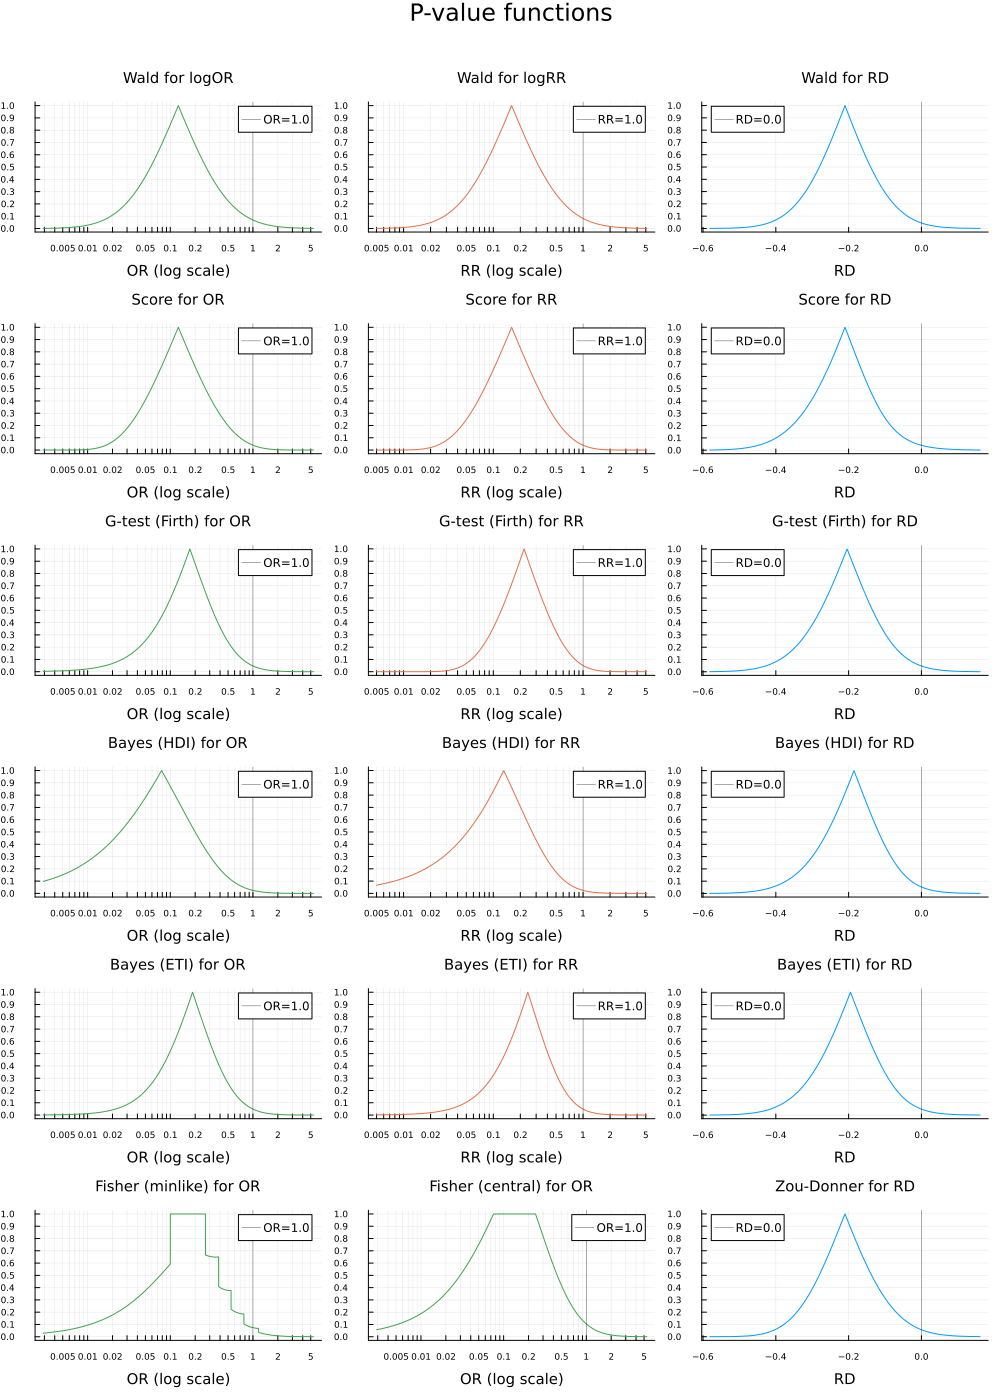

In [19]:
a, b, c, d = 1, 24, 5, 15
print_and_plot_results2x2(a, b, c, d)